## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pydicom as dicom

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = r'D:/Studying/tensorflow_scripts/RetinaNet_project/test_Keras/resnet50_oid_v1.0.0.h5'

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, No

c:\anaconda\envs\tf_lower_version\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# load label to names mapping for visualization purposes
# This field is for the COCO database case. For OID case, please use the labels (500 in total) in the next cell.
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

In [3]:
# This is for OID database case, which contains 500 labels in total.
LEVEL_1_LABELS = ['Accordion', 'Adhesive tape', 'Airplane', 'Alarm clock', 'Alpaca', 'Ambulance', 'Ant', 'Antelope',
                  'Apple', 'Artichoke', 'Asparagus', 'Backpack', 'Bagel', 'Balloon', 'Banana', 'Barge', 'Barrel',
                  'Baseball bat', 'Baseball glove', 'Bat', 'Bathroom cabinet', 'Bathtub', 'Beaker', 'Bee', 'Beehive',
                  'Beer', 'Bell pepper', 'Belt', 'Bench', 'Bicycle', 'Bicycle helmet', 'Bicycle wheel', 'Bidet',
                  'Billboard', 'Billiard table', 'Binoculars', 'Blender', 'Blue jay', 'Book', 'Bookcase', 'Boot',
                  'Bottle', 'Bow and arrow', 'Bowl', 'Box', 'Boy', 'Brassiere', 'Bread', 'Briefcase', 'Broccoli',
                  'Bronze sculpture', 'Brown bear', 'Bull', 'Burrito', 'Bus', 'Bust', 'Butterfly', 'Cabbage',
                  'Cabinetry', 'Cake', 'Cake stand', 'Camel', 'Camera', 'Canary', 'Candle', 'Candy', 'Cannon',
                  'Canoe', 'Carrot', 'Cart', 'Castle', 'Cat', 'Caterpillar', 'Cattle', 'Ceiling fan', 'Cello',
                  'Centipede', 'Chair', 'Cheetah', 'Chest of drawers', 'Chicken', 'Chopsticks', 'Christmas tree',
                  'Coat', 'Cocktail', 'Coconut', 'Coffee', 'Coffee cup', 'Coffee table', 'Coffeemaker', 'Coin',
                  'Common fig', 'Computer keyboard', 'Computer monitor', 'Computer mouse', 'Convenience store',
                  'Cookie', 'Corded phone', 'Countertop', 'Cowboy hat', 'Crab', 'Cricket ball', 'Crocodile',
                  'Croissant', 'Crown', 'Crutch', 'Cucumber', 'Cupboard', 'Curtain', 'Cutting board', 'Dagger',
                  'Deer', 'Desk', 'Dice', 'Digital clock', 'Dinosaur', 'Dog', 'Dog bed', 'Doll', 'Dolphin',
                  'Door', 'Door handle', 'Doughnut', 'Dragonfly', 'Drawer', 'Dress', 'Drinking straw', 'Drum',
                  'Duck', 'Dumbbell', 'Eagle', 'Earrings', 'Egg', 'Elephant', 'Envelope', 'Falcon', 'Fedora',
                  'Filing cabinet', 'Fire hydrant', 'Fireplace', 'Flag', 'Flashlight', 'Flowerpot', 'Flute',
                  'Food processor', 'Football', 'Football helmet', 'Fork', 'Fountain', 'Fox', 'French fries',
                  'Frog', 'Frying pan', 'Gas stove', 'Giraffe', 'Girl', 'Glasses', 'Goat', 'Goggles', 'Goldfish',
                  'Golf ball', 'Golf cart', 'Gondola', 'Goose', 'Grape', 'Grapefruit', 'Guacamole', 'Guitar',
                  'Hamburger', 'Hamster', 'Handbag', 'Handgun', 'Harbor seal', 'Harp', 'Harpsichord', 'Headphones',
                  'Helicopter', 'High heels', 'Honeycomb', 'Horn', 'Horse', 'Hot dog', 'House', 'Houseplant',
                  'Human arm', 'Human beard', 'Human ear', 'Human eye', 'Human face', 'Human foot', 'Human hair',
                  'Human hand', 'Human head', 'Human leg', 'Human mouth', 'Human nose', 'Ice cream', 'Infant bed',
                  'Jacket', 'Jaguar', 'Jeans', 'Jellyfish', 'Jet ski', 'Jug', 'Juice', 'Kangaroo', 'Kettle',
                  'Kitchen & dining room table', 'Kitchen knife', 'Kite', 'Knife', 'Ladder', 'Ladybug', 'Lamp',
                  'Lantern', 'Laptop', 'Lavender', 'Lemon', 'Leopard', 'Lifejacket', 'Light bulb', 'Light switch',
                  'Lighthouse', 'Lily', 'Limousine', 'Lion', 'Lizard', 'Lobster', 'Loveseat', 'Lynx', 'Man',
                  'Mango', 'Maple', 'Measuring cup', 'Mechanical fan', 'Microphone', 'Microwave oven', 'Miniskirt',
                  'Mirror', 'Missile', 'Mixer', 'Mobile phone', 'Monkey', 'Motorcycle', 'Mouse', 'Muffin', 'Mug',
                  'Mule', 'Mushroom', 'Musical keyboard', 'Nail', 'Necklace', 'Nightstand', 'Oboe', 'Office building',
                  'Orange', 'Organ', 'Ostrich', 'Otter', 'Oven', 'Owl', 'Oyster', 'Paddle', 'Palm tree', 'Pancake',
                  'Paper towel', 'Parachute', 'Parrot', 'Pasta', 'Peach', 'Pear', 'Pen', 'Penguin', 'Piano',
                  'Picnic basket', 'Picture frame', 'Pig', 'Pillow', 'Pineapple', 'Pitcher', 'Pizza', 'Plastic bag',
                  'Plate', 'Platter', 'Polar bear', 'Pomegranate', 'Popcorn', 'Porch', 'Porcupine', 'Poster',
                  'Potato', 'Power plugs and sockets', 'Pressure cooker', 'Pretzel', 'Printer', 'Pumpkin',
                  'Punching bag', 'Rabbit', 'Raccoon', 'Radish', 'Raven', 'Refrigerator', 'Rhinoceros', 'Rifle',
                  'Ring binder', 'Rocket', 'Roller skates', 'Rose', 'Rugby ball', 'Ruler', 'Salad',
                  'Salt and pepper shakers', 'Sandal', 'Saucer', 'Saxophone', 'Scarf', 'Scissors', 'Scoreboard',
                  'Screwdriver', 'Sea lion', 'Sea turtle', 'Seahorse', 'Seat belt', 'Segway', 'Serving tray',
                  'Sewing machine', 'Shark', 'Sheep', 'Shelf', 'Shirt', 'Shorts', 'Shotgun', 'Shower', 'Shrimp',
                  'Sink', 'Skateboard', 'Ski', 'Skull', 'Skyscraper', 'Slow cooker', 'Snail', 'Snake', 'Snowboard',
                  'Snowman', 'Snowmobile', 'Snowplow', 'Sock', 'Sofa bed', 'Sombrero', 'Sparrow', 'Spatula',
                  'Spider', 'Spoon', 'Sports uniform', 'Squirrel', 'Stairs', 'Starfish', 'Stationary bicycle',
                  'Stool', 'Stop sign', 'Strawberry', 'Street light', 'Stretcher', 'Studio couch',
                  'Submarine sandwich', 'Suit', 'Suitcase', 'Sun hat', 'Sunflower', 'Sunglasses', 'Surfboard',
                  'Sushi', 'Swan', 'Swim cap', 'Swimming pool', 'Swimwear', 'Sword', 'Table tennis racket',
                  'Tablet computer', 'Taco', 'Tank', 'Tap', 'Tart', 'Taxi', 'Tea', 'Teapot', 'Teddy bear',
                  'Television', 'Tennis ball', 'Tennis racket', 'Tent', 'Tiara', 'Tick', 'Tie', 'Tiger', 'Tin can',
                  'Tire', 'Toaster', 'Toilet', 'Toilet paper', 'Tomato', 'Torch', 'Tortoise', 'Towel', 'Tower',
                  'Traffic light', 'Train', 'Training bench', 'Treadmill', 'Tripod', 'Trombone', 'Truck',
                  'Trumpet', 'Turkey', 'Umbrella', 'Van', 'Vase', 'Vehicle registration plate', 'Violin',
                  'Volleyball', 'Waffle', 'Wall clock', 'Washing machine', 'Waste container', 'Watch',
                  'Watermelon', 'Whale', 'Wheel', 'Wheelchair', 'Whiteboard', 'Willow', 'Window',
                  'Window blind', 'Wine', 'Wine glass', 'Winter melon', 'Wok', 'Woman', 'Wood-burning stove',
                  'Woodpecker', 'Wrench', 'Zebra', 'Zucchini']


LEVEL_2_LABELS = ['Toy', 'Home appliance', 'Plumbing fixture', 'Office supplies', 'Tableware', 'Kitchen appliance',
                  'Couch', 'Bed', 'Table', 'Clock', 'Sculpture', 'Traffic sign', 'Building', 'Person', 'Dessert',
                  'Fruit', 'Shellfish', 'Squash', 'Sandwich', 'Tree', 'Flower', 'Car', 'Boat', 'Aircraft', 'Hat',
                  'Skirt', 'Glove', 'Trousers', 'Footwear', 'Luggage and bags', 'Helmet', 'Bird',
                  'Marine invertebrates', 'Beetle', 'Moths and butterflies', 'Bear', 'Marine mammal', 'Turtle',
                  'Fish', 'Personal care', 'Musical instrument', 'Ball', 'Racket', 'Weapon', 'Telephone',
                  'Drink']

LEVEL_3_LABELS = ['Seafood', 'Watercraft', 'Insect', 'Carnivore']

# Some classes upper to make more than one class for single net
LEVEL_4_LABELS = ['Vegetable', 'Land vehicle', 'Reptile', 'Invertebrate']

# Some classes upper to make more than one class for single net
LEVEL_5_LABELS = ['Furniture', 'Vehicle', 'Animal']

ALL_LABELS = LEVEL_1_LABELS + LEVEL_2_LABELS + LEVEL_3_LABELS + LEVEL_4_LABELS + LEVEL_5_LABELS


len(ALL_LABELS)

list_temp = range(500)
list_index = list(list_temp)

dict_obj = zip(list_index, ALL_LABELS)
labels_to_names = dict(dict_obj)
print(labels_to_names)


{0: 'Accordion', 1: 'Adhesive tape', 2: 'Airplane', 3: 'Alarm clock', 4: 'Alpaca', 5: 'Ambulance', 6: 'Ant', 7: 'Antelope', 8: 'Apple', 9: 'Artichoke', 10: 'Asparagus', 11: 'Backpack', 12: 'Bagel', 13: 'Balloon', 14: 'Banana', 15: 'Barge', 16: 'Barrel', 17: 'Baseball bat', 18: 'Baseball glove', 19: 'Bat', 20: 'Bathroom cabinet', 21: 'Bathtub', 22: 'Beaker', 23: 'Bee', 24: 'Beehive', 25: 'Beer', 26: 'Bell pepper', 27: 'Belt', 28: 'Bench', 29: 'Bicycle', 30: 'Bicycle helmet', 31: 'Bicycle wheel', 32: 'Bidet', 33: 'Billboard', 34: 'Billiard table', 35: 'Binoculars', 36: 'Blender', 37: 'Blue jay', 38: 'Book', 39: 'Bookcase', 40: 'Boot', 41: 'Bottle', 42: 'Bow and arrow', 43: 'Bowl', 44: 'Box', 45: 'Boy', 46: 'Brassiere', 47: 'Bread', 48: 'Briefcase', 49: 'Broccoli', 50: 'Bronze sculpture', 51: 'Brown bear', 52: 'Bull', 53: 'Burrito', 54: 'Bus', 55: 'Bust', 56: 'Butterfly', 57: 'Cabbage', 58: 'Cabinetry', 59: 'Cake', 60: 'Cake stand', 61: 'Camel', 62: 'Camera', 63: 'Canary', 64: 'Candle', 6

## Run detection on example

In [4]:
# Read medical image here.

file_name = r'D:\Studying\RetinaNet_Project\all_DICOM_files\AllDICOMs\50999432_f62fbf38fb208316_MG_L_ML_ANON.dcm'
dicom_data = dicom.dcmread(file_name)
image_gray = dicom_data.pixel_array
image_rbg = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

image =cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)



In [5]:
# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)
print('boxes:', boxes)


processing time:  16.98161029815674
boxes: [[[  0.         0.       422.1296   468.095   ]
  [  0.       374.99515  382.88483  874.5742  ]
  [  0.         0.       414.60718  834.3511  ]
  ...
  [  0.       257.50323  440.794    893.6396  ]
  [  0.        28.514008 462.62665  816.63086 ]
  [ 41.292694 469.1502   506.50104  750.1558  ]]]


In [6]:
print(boxes.shape)
print(scores.shape)
print(labels.shape)
print(scores)
print(labels)

(1, 500, 4)
(1, 500)
(1, 500)
[[0.72563183 0.6455643  0.54166186 0.51225394 0.5014888  0.46614176
  0.44423878 0.3579083  0.3554874  0.33349162 0.3176027  0.31387612
  0.29763466 0.28761232 0.2840638  0.2797818  0.2774651  0.27560163
  0.27348483 0.2553893  0.25370768 0.24705434 0.24107853 0.23693547
  0.23450583 0.22503531 0.22272226 0.21812621 0.2180621  0.21600929
  0.2127249  0.20950833 0.20839041 0.20531961 0.20023257 0.19741404
  0.19004735 0.18987587 0.18704274 0.1841473  0.18324456 0.18303901
  0.17863807 0.1779803  0.17204282 0.16934466 0.16795194 0.167579
  0.16744733 0.1650734  0.15926006 0.1573722  0.15634602 0.1489887
  0.14725932 0.14498764 0.1423491  0.13866353 0.13715503 0.13415724
  0.13320044 0.13316396 0.13214147 0.12995547 0.12398002 0.12382266
  0.12267339 0.12247309 0.12215212 0.12197331 0.12133172 0.12128627
  0.12053224 0.11981231 0.11955148 0.11865839 0.11683771 0.11434489
  0.11414611 0.11409417 0.11197546 0.11197054 0.11126059 0.10884705
  0.10740769 0.105476

c:\anaconda\envs\tf_lower_version\lib\site-packages\keras_retinanet\utils\colors.py:18: UserWarning: Label 121 has no color, returning default.
  warnings.warn('Label {} has no color, returning default.'.format(label))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


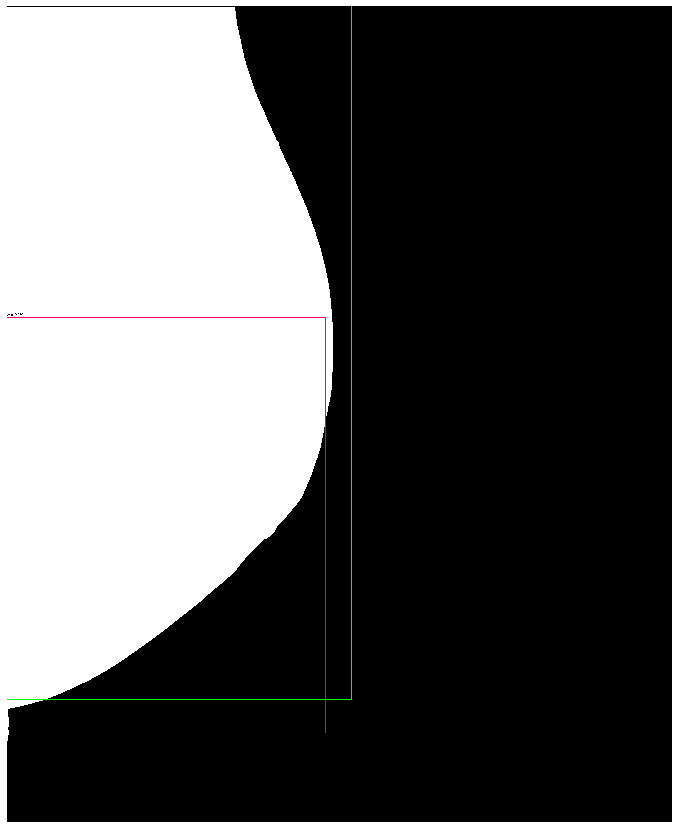

In [7]:
# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.54:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(image_rbg, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image_rbg, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(image_rbg)
plt.show()